In [1]:
from parameters import *
from icecream import ic
from pywarpx import picmi
import unyt
from unyt import unyt_quantity
import yt

yt.enable_parallelism()
yt.set_log_level(40)

_check = 0

suffix = ".pdf"

from pathlib import Path

subdirectories = ["figures"]
for path in subdirectories:
    Path(path).mkdir(parents=True, exist_ok=True)

In [5]:
if _check:
    pass

plotfile = "diags/diag1/plt??????"
ts = yt.load(plotfile)

simulation_length_yt = unyt_quantity.from_astropy(simulation_length)
width_x = 7 / 8 * simulation_length_yt
center_x = simulation_length_yt / 2
center = unyt.unyt_array([width_x / 2, 0 * width_x, 0 * width_x])
L_y_yt = unyt_quantity.from_astropy(L_y)
width = (width_x, L_y_yt)

In [ ]:
def slice_plot(
    fields,
    name,
    _Multipanel=False,
    nrows_ncols=None,
):
    for ds in ts.piter():
        slc = yt.SlicePlot(
            ds, "z", fields, origin="native"
        )  # Create a sliceplot object
        slc.set_axes_unit("km")
        if _Multipanel:
            fig = slc.export_to_mpl_figure(nrows_ncols)
            fig.tight_layout()
            fig.savefig("figures/{}_{}.png".format(str(ds), name))
        else:
            slc.save("figures/")


def slice_sub_plot(
    fields,
    name,
    _Multipanel=False,
    nrows_ncols=None,
):
    for ds in ts.piter():
        slc = yt.SlicePlot(
            ds,
            "z",
            fields,
            origin="native",
            center=center,
            width=width,
        )  # Create a sliceplot object
        slc.set_axes_unit("km")
        if _Multipanel:
            fig = slc.export_to_mpl_figure(nrows_ncols)
            fig.tight_layout()
            fig.savefig("figures/{}_{}_sub.png".format(str(ds), name))
        else:
            slc.save("figures/")

In [ ]:
if 1:
    fields = [
        ("boxlib", "Ex"),
        ("boxlib", "Ey"),
        ("boxlib", "Ez"),
    ]
    _Multipanel = False
    _save = True
    nrows_ncols = (1, 3)
    for ds in ts.piter():
        slc = yt.SlicePlot(
            ds,
            "z",
            fields,
            origin="native",
            center=center,
            width=width,
        )  # Create a sliceplot object
        slc.set_axes_unit("km")

        for field in [("boxlib", "Ex"), ("boxlib", "Ey"), ("boxlib", "Ez")]:
            slc.set_unit(field, "mV/m")
            slc.set_log(field, False)
            slc.set_zlim(field, zmin=(-1000, "mV/m"), zmax=(1000, "mV/m"))
            slc.set_cmap(field=field, cmap="RdBu")

        if _Multipanel:
            fig = slc.export_to_mpl_figure(nrows_ncols)
            fig.tight_layout()

        if _save:
            if _Multipanel:
                fig.savefig("figures/{}_BE_sub{}".format(str(ds), suffix))
            else:
                slc.save("figures/E/", suffix=suffix)

In [ ]:
if 0:
    fields = [
        ("boxlib", "Bx"),
        ("boxlib", "By"),
        ("boxlib", "Bz"),
        ("mesh", "magnetic_field_strength"),
    ]
    # slice_plot(fields, "B", _Multipanel=True, nrows_ncols=(2, 2))
    # slice_sub_plot(fields, "B", _Multipanel=True, nrows_ncols=(2, 2))
    # slc.set_cmap(field=("mesh", "magnetic_field_strength"), cmap="RdBu")

In [2]:
def rho_slice_plot(
    fields,
    directions,
    name,
    _Multipanel=False,
    nrows_ncols=None,
    add_field=None,
):
    for ds in ts.piter():
        if add_field:
            add_field(ds)
        for direction in directions:
            slc = yt.SlicePlot(ds, direction, fields, origin="native")
            slc.set_axes_unit("km")
            slc.set_cmap(field=("boxlib", "density"), cmap="RdBu")

            if _Multipanel:
                fig = slc.export_to_mpl_figure(nrows_ncols)
                fig.tight_layout()
                fig.savefig(
                    "figures/{}_Slice_{}_{}.png".format(str(ds), direction, name)
                )
            else:
                slc.save("figures/")


def rho_slice_sub_plot(
    fields,
    directions,
    name,
    _Multipanel=False,
    nrows_ncols=None,
    add_field=None,
):
    for ds in ts.piter():
        if add_field:
            add_field(ds)
        for direction in directions:
            slc = yt.SlicePlot(
                ds, direction, fields, origin="native", center=center, width=width
            )
            slc.set_axes_unit("km")
            slc.set_cmap(field=("boxlib", "density"), cmap="RdBu")

            if _Multipanel:
                fig = slc.export_to_mpl_figure(nrows_ncols)
                fig.tight_layout()
                fig.savefig(
                    "figures/{}_Slice_sub_{}_{}.png".format(str(ds), direction, name)
                )
            else:
                slc.save("figures/")

In [3]:
def _density_e(field, data):
    return data["boxlib", "rho_electron"] / -picmi.constants.q_e * unyt.m**-3


def _density_p(field, data):
    return data["boxlib", "rho_proton"] / picmi.constants.q_e * unyt.m**-3


def _density(field, data):
    return (
        data["boxlib", "rho_proton"] / picmi.constants.q_e
        + data["boxlib", "rho_electron"] / picmi.constants.q_e
    ) * unyt.m**-3


def add_density_field(ds):
    ds.add_field(
        name=("boxlib", "density_electron"),
        function=_density_e,
        sampling_type="local",
        units="cm**-3",
        display_name=r"\rho_e",
    )
    ds.add_field(
        name=("boxlib", "density_proton"),
        function=_density_p,
        sampling_type="local",
        units="cm**-3",
        display_name=r"\rho_p",
    )
    ds.add_field(
        name=("boxlib", "density"),
        function=_density,
        sampling_type="local",
        units="cm**-3",
        display_name=r"\rho",
    )

In [ ]:
if 0:
    # directions = ["z"]
    # fields = [("boxlib", "rho_electron"), ("boxlib", "rho_proton"), ("boxlib", "rho")]
    # rho_slice_plot(fields, directions, "rho", _Multipanel=True, nrows_ncols=(3, 1))
    directions = ["z"]
    fields = [
        ("boxlib", "density_electron"),
        ("boxlib", "density_proton"),
        ("boxlib", "density"),
    ]

    _Multipanel = 0
    nrows_ncols = (1, 3)
    _save = True

    for ds in ts.piter():
        add_density_field(ds)
        for direction in directions:
            slc = yt.SlicePlot(
                ds, direction, fields, origin="native", center=center, width=width
            )
            slc.set_axes_unit("km")
            for field in fields:
                slc.set_cmap(field=field, cmap="RdBu")

            if _Multipanel:
                fig = slc.export_to_mpl_figure(nrows_ncols)
                # fig.suptitle("Density Plot ({:.3f})".format(ds.current_time.to('s')))
                fig.tight_layout()

            if _save:
                if _Multipanel:
                    fig.savefig(
                        "figures/{}_Slice_sub_{}_density{}".format(
                            str(ds), direction, suffix
                        )
                    )
                else:
                    slc.save("figures/density/", suffix=suffix)

## Time Series Movie

In [9]:
def animations(ts, field):

    from matplotlib.animation import FuncAnimation

    ds = ts[0]
    add_density_field(ds)

    plot = yt.SlicePlot(
        ds,
        "z",
        field,
        origin="native",
    )
    
    fig = plot.plots[field].figure

    # animate must accept an integer frame number. We use the frame number
    # to identify which dataset in the time series we want to load
    def animate(i):
        ds = ts[i]
        add_density_field(ds)
        plot._switch_ds(ds)

    animation = FuncAnimation(fig, animate, frames=len(ts))
    animation.save("{}_animation.mp4".format(field[1]))


if 0:
    plotfile = "diags/diag1/plt??????"
    ts = yt.load(plotfile)
    fields = [
        ("boxlib", "density"),
        ("boxlib", "density_proton"),
        ("boxlib", "density_electron"),
    ]

    for field in fields:
        animations(ts, field)

In [ ]:
def get_species(ds):
    psset = set()
    for ps in ds.particle_types:
        if ps == "all":
            continue
        psset.add(ps)
    return list(psset)

In [ ]:
@yt.particle_filter(requires=["particle_position_x"], filtered_type="electron")
def filtered_electron(pfilter, data):
    filter = data[(pfilter.filtered_type, "particle_position_x")] < simulation_length_yt
    return filter


@yt.particle_filter(requires=["particle_position_x"], filtered_type="proton")
def filtered_proton(pfilter, data):
    filter = data[(pfilter.filtered_type, "particle_position_x")] < simulation_length_yt
    return filter

In [ ]:
def particle_plot(filter=False):
    plotfile = "diags/diag2/plt??????"
    ts = yt.load(plotfile)
    for ds in ts.piter():
        # pslist = get_species(ds)
        if filter:

            ds.add_particle_filter("filtered_electron")
            ds.add_particle_filter("filtered_proton")

        for ps in ds.particle_types:

            if filter:
                if "filtered" not in ps:
                    continue

            ds.index
            ds.field_info[ps, "particle_momentum_x"].take_log = False
            ds.field_info[ps, "particle_momentum_y"].take_log = False
            ds.field_info[ps, "particle_momentum_z"].take_log = False

            name = "figures/{}/".format(ps)

            p = yt.ParticlePlot(
                ds,
                (ps, "particle_position_x"),
                (ps, "particle_position_y"),
                (ps, "particle_weight"),
                origin="native",
                center=center,
                width=width,
            )
            p.save(name, suffix=suffix)
            p = yt.ParticlePlot(
                ds,
                (ps, "particle_position_x"),
                (ps, "particle_momentum_x"),
                (ps, "particle_weight"),
            )
            p.save(name, suffix=suffix)
            p = yt.ParticlePlot(
                ds,
                (ps, "particle_position_x"),
                (ps, "particle_momentum_y"),
                (ps, "particle_weight"),
            )
            p.save(name, suffix=suffix)
            p = yt.ParticlePlot(
                ds,
                (ps, "particle_position_x"),
                (ps, "particle_momentum_z"),
                (ps, "particle_weight"),
            )
            p.save(name, suffix=suffix)
            # p = yt.ParticlePlot(
            #     ds,
            #     (ps, "particle_momentum_x"),
            #     (ps, "particle_momentum_y"),
            #     (ps, "particle_weight"),
            # )
            # p.save(name)
            # p = yt.ParticlePlot(
            #     ds,
            #     (ps, "particle_momentum_x"),
            #     (ps, "particle_momentum_z"),
            #     (ps, "particle_weight"),
            # )
            # p.save(name)
            # p = yt.ParticlePlot(
            #     ds,
            #     (ps, "particle_momentum_z"),
            #     (ps, "particle_momentum_y"),
            #     (ps, "particle_weight"),
            # )
            # p.save(name)

In [ ]:
if 0:
    particle_plot()

## Particle data analysis

In [25]:
plotfile = "diags/diag2/plt??????"
ts = yt.load(plotfile)
ds = ts[-1]
ad = ds.all_data()
df = ad.to_dataframe([("proton", "particle_momentum_x"), ("proton", "particle_momentum_y")])

In [27]:
import proplot as pplt

(array([1.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00,
        1.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 2.00000e+00, 0.00000e+00,
        0.00000e+00, 2.00000e+00, 2.00000e+00, 0.00000e+00, 0.00000e+00,
        4.00000e+00, 4.00000e+00, 4.00000e+00, 6.00000e+00, 2.00000e+00,
        7.00000e+00, 1.10000e+01, 1.90000e+01, 2.50000e+01, 2.40000e+01,
        4.80000e+01, 5.70000e+01, 6.90000e+01, 8.50

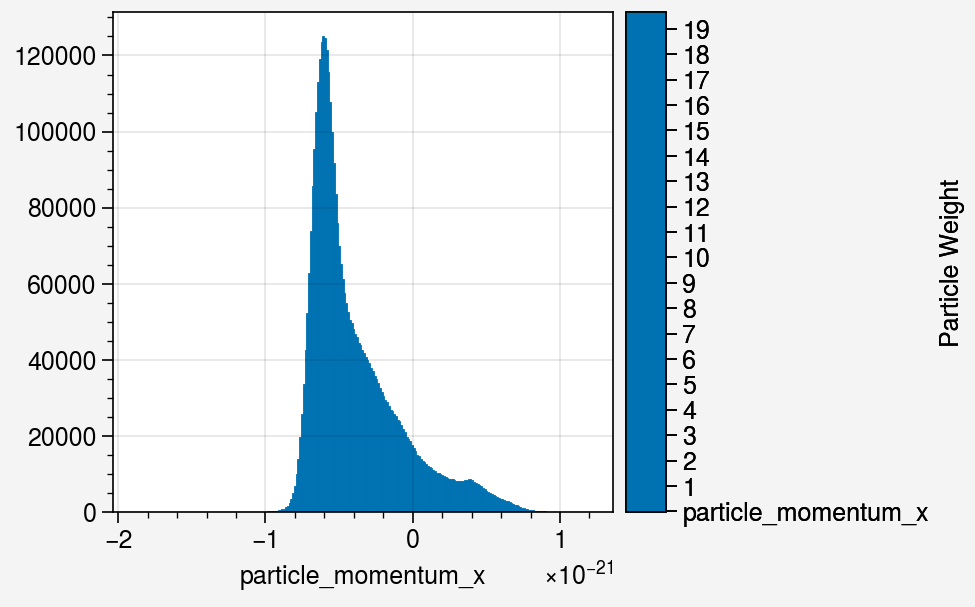

In [32]:
fig = pplt.figure()
ax = fig.subplot()
ax.hist("particle_momentum_x",bins = 256,data=df,colorbar='r',colorbar_kw={'label':"Particle Weight"})
# ax.format(xlabel='Distance above lunar surface', ylabel = r'$u_x$')

In [21]:
if 1:
    plotfile = "diags/diag2/plt??????"
    ts = yt.load(plotfile)
    ds = ts[-1]
    ad = ds.all_data()

    particle_types = ["electron", "proton"]

    for ps in particle_types:

        name = "figures/{}/Last".format(ps)
        profiles = []
        labels = []

        ds.index
        ds.field_info[ps, "particle_momentum_x"].take_log = False
        ds.field_info[ps, "particle_momentum_y"].take_log = False
        ds.field_info[ps, "particle_momentum_z"].take_log = False
        profiles.append(
            yt.create_profile(
                ad,
                [(ps, "particle_momentum_x")],
                fields=[
                    (ps, "particle_weight"),
                ],
                weight_field=(ps, 'particle_weight'),
                accumulation=True,
            )
        )

        plot = yt.ProfilePlot.from_profiles(profiles)
        plot.annotate_title(
            "{} Momentum Profile ({:.3f})".format(
                ps.capitalize(), ds.current_time.to("s")
            )
        )
        plot.save(name, suffix=suffix)

### Particle momentum profile with time

In [14]:
plotfile = "diags/diag2/plt??????"
ts = yt.load(plotfile)
ds = ts[0]
ds.derived_field_list
ds.field_list

[('all', 'particle_cpu'),
 ('all', 'particle_id'),
 ('all', 'particle_momentum_x'),
 ('all', 'particle_momentum_y'),
 ('all', 'particle_momentum_z'),
 ('all', 'particle_position_x'),
 ('all', 'particle_position_y'),
 ('all', 'particle_weight'),
 ('boxlib', 'Bx'),
 ('boxlib', 'By'),
 ('boxlib', 'Bz'),
 ('boxlib', 'Ex'),
 ('boxlib', 'Ey'),
 ('boxlib', 'Ez'),
 ('boxlib', 'jx'),
 ('boxlib', 'jy'),
 ('boxlib', 'jz'),
 ('electron', 'particle_cpu'),
 ('electron', 'particle_id'),
 ('electron', 'particle_momentum_x'),
 ('electron', 'particle_momentum_y'),
 ('electron', 'particle_momentum_z'),
 ('electron', 'particle_position_x'),
 ('electron', 'particle_position_y'),
 ('electron', 'particle_weight'),
 ('nbody', 'particle_cpu'),
 ('nbody', 'particle_id'),
 ('nbody', 'particle_momentum_x'),
 ('nbody', 'particle_momentum_y'),
 ('nbody', 'particle_momentum_z'),
 ('nbody', 'particle_position_x'),
 ('nbody', 'particle_position_y'),
 ('nbody', 'particle_weight'),
 ('proton', 'particle_cpu'),
 ('proton

In [104]:
if 1:
    plotfile = "diags/diag2/plt??????"
    ts = yt.load(plotfile)

    particle_types = ["electron", "proton"]
    # particle_types = ds.particle_types

    # Loop over each dataset in the time-series.
    for ps in particle_types:

        profiles = []
        labels = []
        name = "figures/{}/Time".format(ps)
        storage = {}
        for ds in ts:
            # Create a data container to hold the whole dataset.

            ad = ds.all_data()
            # Create a 1d profile of density vs. temperature.

            ds.index
            ds.field_info[ps, "particle_momentum_x"].take_log = False
            ds.field_info[ps, "particle_momentum_y"].take_log = False
            ds.field_info[ps, "particle_momentum_z"].take_log = False
            profiles.append(
                yt.create_profile(
                    ad,
                    [(ps, "particle_position_x")],
                    fields=[
                        (ps, "particle_momentum_x"),
                        (ps, "particle_momentum_y"),
                        (ps, "particle_momentum_z"),
                    ],
                    weight_field=(ps, "particle_weighting"),
                )
            )

            # Add labels
            labels.append("time = {:.3f} ({})".format(ds.current_time.to("s"), ps))

        # Create the profile plot from the list of profiles.
        plot = yt.ProfilePlot.from_profiles(profiles, labels=labels)
        plot.save(name, suffix=suffix)

In [108]:
if 0:
    plotfile = "diags/diag2/plt??????"
    ts = yt.load(plotfile)
    ds = ts[-1]
    ad = ds.all_data()

    particle_types = ["electron", "proton"]

    for ps in particle_types:

        name = "figures/{}/Last".format(ps)
        profiles = []
        labels = []

        ds.index
        ds.field_info[ps, "particle_momentum_x"].take_log = False
        ds.field_info[ps, "particle_momentum_y"].take_log = False
        ds.field_info[ps, "particle_momentum_z"].take_log = False
        profiles.append(
            yt.create_profile(
                ad,
                [(ps, "particle_position_x")],
                fields=[
                    (ps, "particle_momentum_x"),
                    (ps, "particle_momentum_y"),
                    (ps, "particle_momentum_z"),
                ],
                weight_field=(ps, "particle_weighting"),
            )
        )

        plot = yt.ProfilePlot.from_profiles(profiles)
        plot.annotate_title(
            "{} Momentum vs Distance Plot ({:.3f})".format(
                ps.capitalize(), ds.current_time.to("s")
            )
        )
        plot.set_xlabel(r"$\rm{\ Distance\ Above\ the\ Surface\ (km)}$")
        plot.set_unit((ps, "particle_position_x"), "km")
        plot.save(name, suffix=suffix)

In [ ]:
if False:
    for ps in ds.particle_types:

        ds.index
        ds.field_info[ps, "particle_momentum_x"].take_log = False
        ds.field_info[ps, "particle_momentum_y"].take_log = False
        ds.field_info[ps, "particle_momentum_z"].take_log = False

        p = yt.ParticlePlot(
            ds,
            (ps, "particle_position_x"),
            (ps, "particle_momentum_x"),
            (ps, "particle_weight"),
        )

        p = yt.ParticlePlot(
            ds,
            (ps, "particle_position_x"),
            (ps, "particle_momentum_y"),
            (ps, "particle_weight"),
        )
        p = yt.ParticlePlot(
            ds,
            (ps, "particle_position_x"),
            (ps, "particle_momentum_z"),
            (ps, "particle_weight"),
        )